In [1]:
#Import the python libraries
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#Get the stock tickers in the portfolio 
assets = ['AMD','NFLX','AAPL','GOOG']

In [3]:
#Assign weights to the stocks. 
weights = np.array([0.25,0.25,0.25,0.25])

In [4]:
# Get the stock/ portfolio starting date
stockStartDate = '2015-01-01'

In [5]:
# Get the stocks' ending date (today)
today = datetime.today().strftime('%Y-%m-%d')
today

'2021-06-08'

In [6]:
# Create a dataframe to store the adjusted close price of the stocks
df = pd.DataFrame()

# Store the adjusted close price of the stock into the df
for stock in assets:
  df[stock] = web.DataReader(stock,data_source='yahoo',start=stockStartDate,end=today)['Adj Close']

In [7]:
df.head()

,AMD,NFLX,AAPL,GOOG
Date,,,,
2015-01-02,2.67,49.848572,24.819241,523.373108
2015-01-05,2.66,47.311428,24.120045,512.463013
2015-01-06,2.63,46.501431,24.122320,500.585632
2015-01-07,2.58,46.742859,24.460564,499.727997
2015-01-08,2.61,47.779999,25.400398,501.303680


In [8]:
df.shape

(1619, 4)

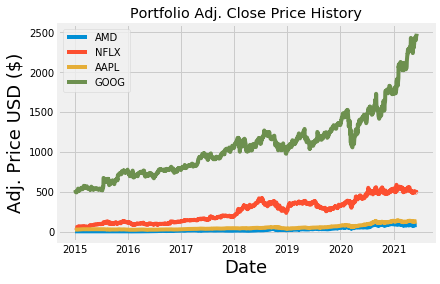

In [9]:
# Visually show the stock/ portfolio
title = 'Portfolio Adj. Close Price History'

# Get the stocks
my_stocks = df

# Create and plot the graph
for c in my_stocks.columns.values:
  plt.plot(my_stocks[c],label=c)

plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adj. Price USD ($)',fontsize=18)
plt.legend(my_stocks.columns.values,loc='upper left')
plt.show()

In [10]:
# show the daily simple return
returns = df.pct_change()
returns

,AMD,NFLX,AAPL,GOOG
Date,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,-0.003745,-0.050897,-0.028172,-0.020846
2015-01-06,-0.011278,-0.017121,0.000094,-0.023177
2015-01-07,-0.019011,0.005192,0.014022,-0.001713
2015-01-08,0.011628,0.022188,0.038422,0.003153
...,...,...,...,...
2021-06-02,0.014355,0.000321,0.006276,-0.003511
2021-06-03,-0.020617,-0.019650,-0.012154,-0.006885
2021-06-04,0.016193,0.010849,0.019022,0.019608


In [11]:
# Create and show the annualized covariance matrix
cov_matrix_annual = returns.cov()*252
cov_matrix_annual

,AMD,NFLX,AAPL,GOOG
AMD,0.388759,0.078938,0.070110,0.052573
NFLX,0.078938,0.178975,0.052126,0.055039
AAPL,0.070110,0.052126,0.087531,0.048127
GOOG,0.052573,0.055039,0.048127,0.072932


In [12]:
# Calculate the portfolio variance
port_variance = np.dot(weights.T,np.dot(cov_matrix_annual,weights))
port_variance

0.09012656116585994

In [13]:
# Calculate the portfolio volatility aka standard deviation
port_volatility = np.sqrt(port_variance)
port_volatility

0.30021086117237655

In [14]:
# Calculate the annual portfolio return
portfolio_simple_annual_return = np.sum(returns.mean()*weights)*252
portfolio_simple_annual_return

0.43546256342077144

In [15]:
# Sow the expected annual return, volatility (risk), and variance
percent_var = str(round(port_variance,2)*100)+'%'
percent_vola = str(round(port_volatility,2)*100)+'%'
percent_ret = str(round(portfolio_simple_annual_return,2)*100)+'%'

print('Expected annual return: '+percent_ret)
print('Annual volatility/ risk: '+percent_vola)
print('Annual variance: '+percent_var)

Expected annual return: 44.0%
Annual volatility/ risk: 30.0%
Annual variance: 9.0%


In [16]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

In [17]:
# Portfolio Optimization

# Calculate the expected returns and the annualized sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximum sharpe ratio
ef = EfficientFrontier(mu,S,weight_bounds=(None,None))
ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3] == 1)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights() 
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('AMD', 0.28004), ('NFLX', 0.26248), ('AAPL', 0.16481), ('GOOG', 0.29267)])
Expected annual return: 43.7%
Annual volatility: 30.9%
Sharpe Ratio: 1.35


(0.436657601464819, 0.309426862265964, 1.3465463160295572)

In [18]:
# Get the discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights,latest_prices,total_portfolio_value = 50000)

allocation,leftover = da.lp_portfolio()
print('Discrete allocation: ',allocation)
print('Funds remaining: ${:.2f}'.format(leftover))

Discrete allocation:  {'AMD': 174, 'NFLX': 26, 'AAPL': 65, 'GOOG': 6}
Funds remaining: $17.91


OrderedDict([('AMD', 0.28004), ('NFLX', 0.26248), ('AAPL', 0.16481), ('GOOG', 0.29267)])
Expected annual return: 43.7%
Annual volatility: 30.9%
Sharpe Ratio: 1.35


(0.436657601464819, 0.309426862265964, 1.3465463160295572)

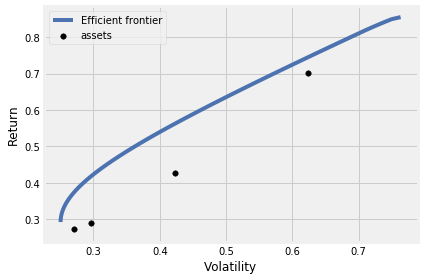

In [19]:
# Portfolio Optimization

# Calculate the expected returns and the annualized sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximum sharpe ratio
ef = EfficientFrontier(mu,S,weight_bounds=(None,None))
ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3] == 1)
plotting.plot_efficient_frontier(ef)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights() 
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

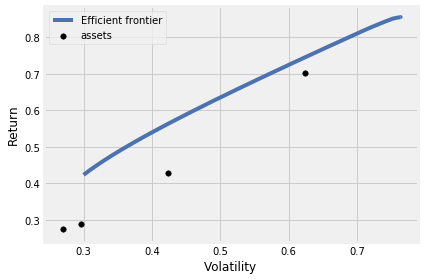

OrderedDict([('AMD', 0.28004), ('NFLX', 0.26248), ('AAPL', 0.16481), ('GOOG', 0.29267)])
Expected annual return: 43.7%
Annual volatility: 30.9%
Sharpe Ratio: 1.35


(0.436657601464819, 0.309426862265964, 1.3465463160295572)

In [20]:
# Portfolio Optimization

# Calculate the expected returns and the annualized sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximum sharpe ratio
ef = EfficientFrontier(mu,S,weight_bounds=(None,None))
ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3] == 1)
# 100 portfolios with risks between 0.10 and 0.30
risk_range = np.linspace(0.30, 0.80, 1000)
plotting.plot_efficient_frontier(ef, ef_param="risk", ef_param_range=risk_range,show_assets=True, showfig=True)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights() 
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

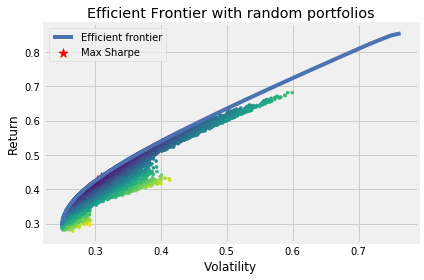

In [21]:
# Calculate the expected returns and the annualized sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximum sharpe ratio
ef = EfficientFrontier(mu,S,weight_bounds=(None,None))
ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3] == 1)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()